--- 
description: Here we show how to solve vertex cover problem using JijZept and JijModeling.
---

# Vertex Cover Problem

We show how to solve vertex cover problem using JijZept and [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/).
This problem is also mentioned in 4.3. Vertex Cover on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is Vertex Cover Problem?

The vertex cover problem is defined as follows.
Given an undirected graph $G = (V,E)$, count the smallest number of vertices that can be “colored” such that every edge connects vertices that have different colors from each other.
In other words, we want to have a minimum set of vertices that "covers" all the edges in the graph.

For example, consider the following undirected graph:

![](./assets/16_vertex_cover.jpg)

In this graph, the vertices are labeled by A, B, C, D, E, and F, and the edges are expressed by lines connecting the vertices.
The vertex cover for this graph is \{B, C, D\}, which contains at least one vertex from each edge:

- Edge (A, B) is covered by vertex B
- Edge (A, C) is covered by vertex C
- Edge (B, C) is covered by vertex B and C
- Edge (B, D) is covered by vertex B and D
- Edge (C, E) is covered by vertex C
- Edge (D, E) is covered by vertex D
- Edge (D, F) is covered by vertex D

## Mathematical model

First, we introduce binary variables $x_{v}$ that takes 1 if the vertex $v$ is colored and takes 0 otherwise.

### Constraint: every edge has at least one colored vertex

This constaaint ensures that, for every edge $(uv)$, either $u$ or $v$ or both are included in the vertex cover.

$$
\quad \sum_{(u,v) \in E} (1-x_u)(1-x_v) = 0.
$$

### Objective function: minimize the size of the vertex cover

This can be interpreted to the bit population:
$$
\quad \min \sum_v x_v.
$$

## Modeling by JijModeling

Next, we show how to implement above equations using JijModeling.
We first define the variables in the mathematical model described above.
(*Cf.* graph partitioning problem.)

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
x = jm.BinaryVar('x', shape=(V,))
u = jm.Element('u', V)
e = jm.Element('e', E)

### Constraint

The constraint and the objective function are written as:

In [3]:
problem = jm.Problem('Vertex Cover')
problem += jm.Constraint('color', jm.sum(e, (1-x[e[0]])*(1-x[e[1]]))==0)

problem += x[:].sum()

On Jupyter Notebook, one can check the problem statement in a human-readable way by hitting


In [4]:
problem

## Prepare an instance

We prepare a graph using [Networkx](https://networkx.org/).

In [5]:
import networkx as nx

# set the number of vertices
inst_V = 12
# create a random graph
inst_G = nx.gnp_random_graph(inst_V, 0.4)
# get information of edges
inst_E = [list(edge) for edge in inst_G.edges]
instance_data = {'V': inst_V, 'E': inst_E}

This graph is shown below.

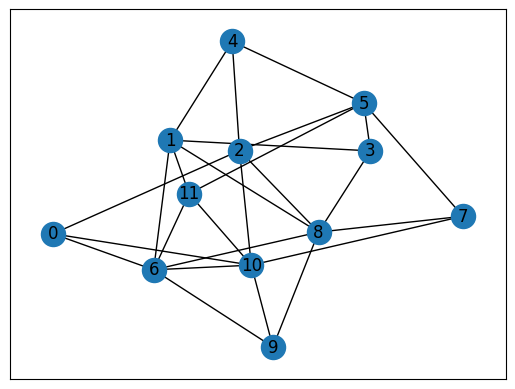

In [6]:
import matplotlib.pyplot as plt

nx.draw_networkx(inst_G, with_labels=True)
plt.show()

## Solve by JijZept's SA

We solve this problem using JijSASampler.
We also turn on a parameter search function by setting `search=True`.

In [7]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="../../../config.toml")
# solve problem
response = sampler.sample_model(problem, instance_data, multipliers={'color': 0.5}, num_reads=100, search=True)

## Visualize solution

The optimized solution can be seen as below.


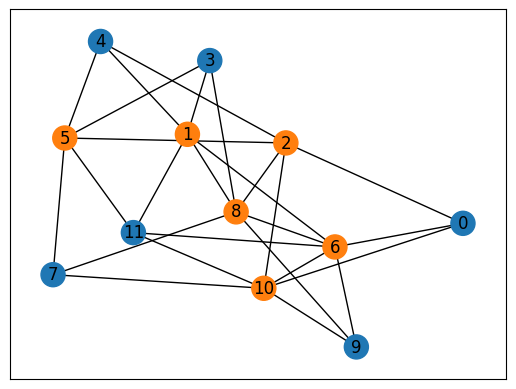

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# get sampleset
sampleset = response.get_sampleset()
# extract feasible samples
feasible_samples = sampleset.feasibles()
# get the values of feasible objectives
feasible_objectives = [sample.eval.objective for sample in feasible_samples]
if len(feasible_objectives) == 0:
    print("No feasible sample found ...")
else:
    # get the index of the lowest feasible objectives
    lowest_index = np.argmin(feasible_objectives)
    # get the lowest solution
    lowest_solution = feasible_samples[lowest_index].var_values["x"].values
    # get the indices of x == 1
    x_indices = [key[0] for key in lowest_solution.keys()]
    # set color list for visualization
    cmap = plt.get_cmap("tab10")
    # initialize vertex color list
    node_colors = [cmap(0)] * instance_data["V"]
    # set vertex color list
    for i in x_indices:
        node_colors[i] = cmap(1)
    # draw the graph
    nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
    plt.show()

The above figure clearly show a feasible vertex cover for the given graph.
